## Infant (case study)


#### The colonization process of the infant gut microbiome has been called chaotic, but this view could reflect insufficient documentation of the factors affecting the microbiome. We performed a 2.5-year case study of the assembly of the human infant gut microbiome to relate life events to microbiome composition and function. Sixty fecal samples were collected from a healthy infant along with a diary of diet and health status. Analysis of >300,000 16S rRNA genes indicated that the phylogenetic diversity of the microbiome increased gradually over time and that changes in community composition conformed to a smooth temporal gradient. In contrast, major taxonomic groups showed abrupt shifts in abundance corresponding to changes in diet or health. Community assembly was nonrandom: we observed discrete steps of bacterial succession punctuated by life events. Furthermore, analysis of ~500,000 DNA metagenomic reads from 12 fecal samples revealed that the earliest microbiome was enriched in genes facilitating lactate utilization, and that functional genes involved in plant polysaccharide metabolism were present prior to the introduction of solid food, priming the infant gut for an adult diet. However, ingestion of table foods caused a sustained increase in the abundance of Bacteroidetes, elevated fecal short chain fatty acid levels, enrichment of genes associated with carbohydrate utilization, vitamin biosynthesis and xenobiotic degradation, and a more stable community composition, all of which are characteristic of the adult microbiome. This study revealed that seemingly chaotic shifts in the microbiome could be attributed to life events.


### P.I.  Ruth Ley (Cornell University)
### [Data and Source](https://qiita.ucsd.edu/study/description/101#)

In [23]:
# Import libraries
from __future__ import division
import warnings; warnings.simplefilter('ignore') #for PCoA warnings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from DIECODE import untangle,fetch

## First we import the .biom OTU table and tab delimited mapping file (qiime style).

In [24]:
map_file='data/benchmarking/infant_time_series_map.txt' #import metadata
in_biom='data/benchmarking/infant_time_series.biom' #import biom file
otutabledf,mappingdf,taxnames=fetch.dfimport(in_biom,map_file)

# Supervised machine learning will allow us to identify complex patterns in our OTU table that correlate with mapping data categories such as environmental factors or patient outcomes. 

# Machine learning on OTU tables can be difficult due to the number of zeros. Matrix completion is a method where unknown values can be approximated using the known data. This prevents the low-density in OTU tables.

### This allows you to view the underlying trends in the data

<img src="etc/decomp.png">

# This will help us find important trends in the data quickly

In [25]:
# This command will do machine leanring on your otu table and mapping file. It ouputs your scores

# The main input is just the otu table and the mapping data. 

# complete will determine if you do completion (iteration is the number of iterations for the completion)

infantscores,infant_low_rank_data=untangle.machine_learning(otutabledf,mappingdf.T,complete=True,iteration=62,mean_count=1)

## Now we can visualize the output of the machine learning infant scores

## The cross-validation scores give you a metric of some of the mapping categories that are most correlated to the patterns in your data. Here we see if the infant is eating Solid Food is an important category.

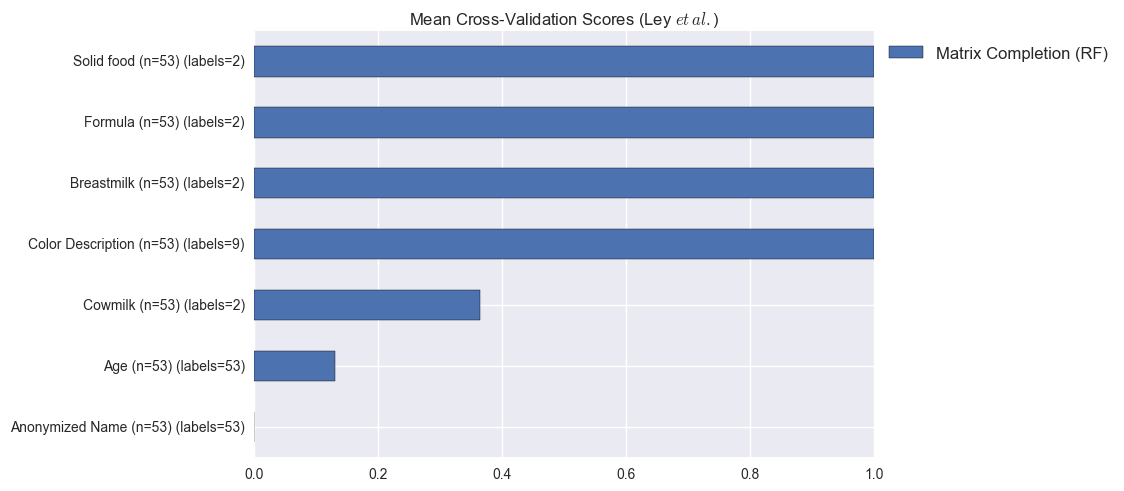

In [26]:
fig, (ax1) = plt.subplots(ncols=1, nrows=1)
infantscores.columns=['Matrix Completion (RF)']
infantscores.sort_values(['Matrix Completion (RF)'], ascending = [True], inplace = True)
#rename a few
infantscores.plot(kind='barh',title='Mean Cross-Validation Scores (Ley $et \, al.$)',xlim=(0,1),ax=ax1)
handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[::-1], labels[::-1],loc=2,prop={'size':12}, bbox_to_anchor=(1.0, 1.0))
ax1.set_ylabel('')
plt.show()

# Extract Important OTUs (features) for  Solid Food

### Now that you know  Solid Food is an important category you would like to find out what pattern of OTUs best explain that change at each point in your mapping data. Here we plot the pattern that the machine learning found at each  Solid Food. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

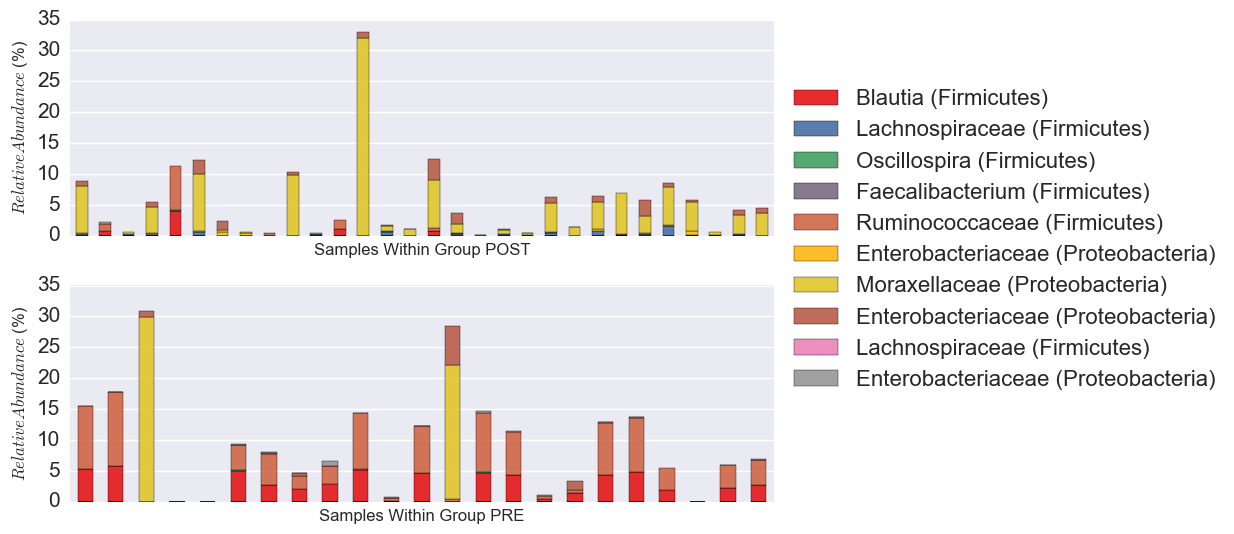

In [32]:
# get important features
n=10 #this will tell the command how many bacteria to plot
niche='Solid food' #this is a mapping file catagory you would like to plot
filter_names=['Unknown','Not applicable'] #this is a list of labels in the mapping you would like removed such as Unknown or Not available
# complete will determine if you do completion (iteration is the number of iterations for the completion)
sfotus,sfmappingdf=fetch.matchtable(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(filter_names)].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=62)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

## This can help guide the biology quickly to important environmental factors or patient data. It can also quickly extract OTU pattern that is predictive of the identified states.

## For example here we find that the OTUs that best differentiate the samples between infants who have solid food and those who have not are in the phylum Firmicutes and Proteobacteria. More specifically we see that infants that have not had solid food have high abundance of Ruminococcaceae and Blautia compared to those who have had solid food with higher abundance of Proteobacteria. 

## Now we can visualize the clustering in clr-PCA and extract variant OTUs along the axis for Solid Food 

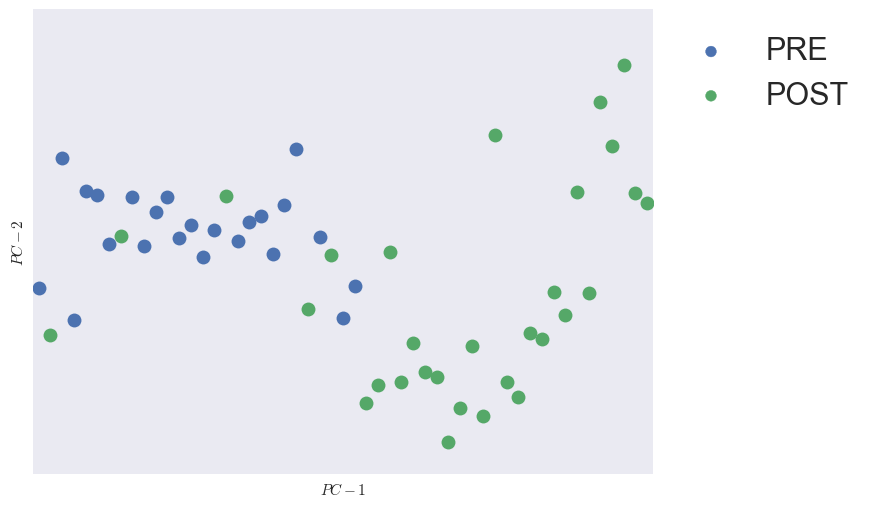

In [30]:
# This command will output a clr-PCA plot for a specified mapping file catagory (we will reuse niche here)
fig,OTUweightsPC1,OTUweightsPC2=untangle.pca_plot(sfotus,sfmappingdf,niche)
plt.show()

# We can now see the OTUs that are causing the clustering difference between the pre and post solid food groups along PC-1

## Learning Bacteria that Cause Variance Along Axis PC-1

#### Recovering information about features from PCA eigenvectors  


### Suppose we would like to see how the bacteria change along this first axis of pH since our machine learning identified that as the best category from the metadata.

### If the gradient change is along that axis we can then say what bacteria changes the most along that axis.

### The principal components are a linear combination of original features in N dimensional space

### $ PC^{j} = \beta_{1}^{j}X_{1} +  \beta_{2}^{j}X_{2} + ... + \beta_{N}^{j}X_{N} $

#### Where $\beta_{N}^{j}$ are weights and $X_{N}$ is the original variables

#### Therefore the coefficients are the transform of an identity matrix of shape X

#### Each column of the transformed coefficient matrix are the coefficients $\beta_{N}^{j}$ weights pertaining to each principal component $ PC^{j}$. 

#### In other words we can examine the weights on each OTU or bacteria that best explain the variance of each axis in our PCA graph. 

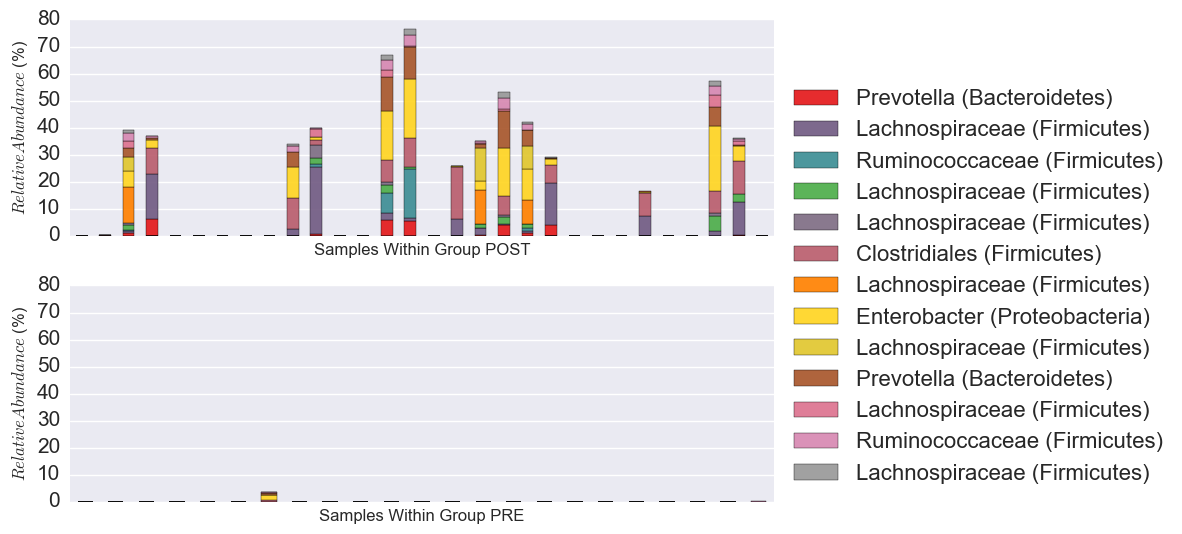

In [33]:
#plot 
#Note: we are using PC-1 here because the clusters are along that axis
n=13 #this will tell the command how many bacteria to plot
# taxanames is from the biom import,, it is a mapping file of the taxaonomy for each OTU
fig=untangle.feature_vis(sfotus,sfmappingdf,list(OTUweightsPC1.index[:n]),niche,taxnames)
plt.show()

## Having direct OTU based explanation to the PCA axis we can see those OTUs that vary the most along the axis.

## For example here we find that the OTUs that best differentiate the samples between infants who have solid food and those who have not are in the phylum Firmicutes.

# Get important features from machine learning for the important category of Formula (True/False) (drinks Formula milk / does not drink Formula milk)

## We will follow the exact same process as we did for solid food.

### Now that you know formula is an important category you would like to find out what pattern of OTUs best explain that change at each point in your mapping data. Here we plot the pattern that the machine learning found at each formula. The taxonomy labels are the lowest classification assigned with the phylum in parenthesis.

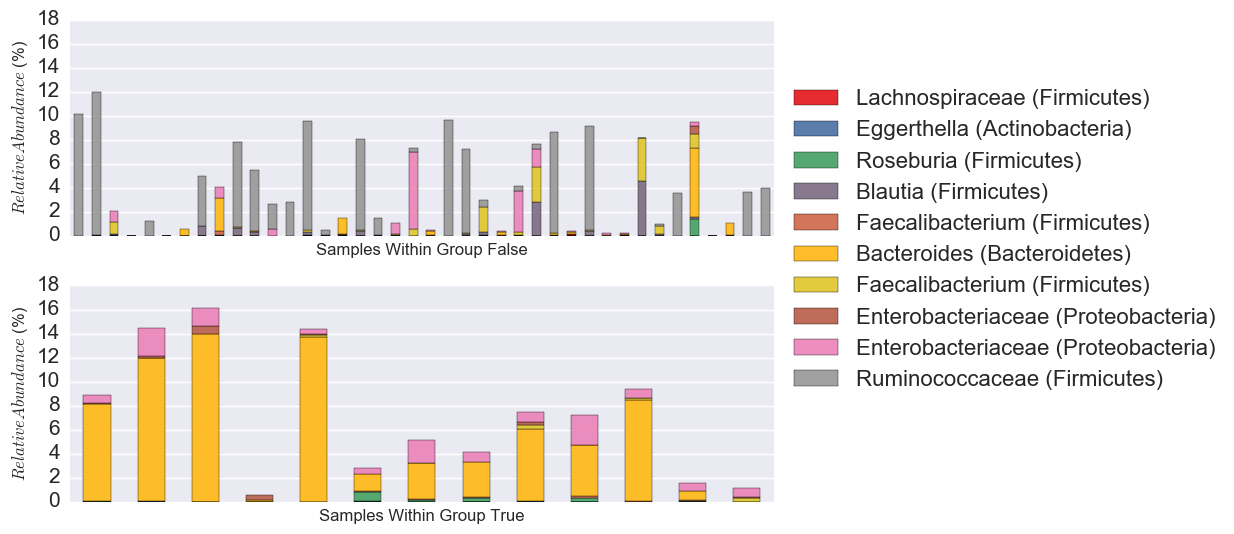

In [42]:
# get important features

# we will need to change the plotting catagory
niche='Formula' #this is a mapping file catagory you would like to plot (notice this is the only thing that changed)

n=10 #this will tell the command how many bacteria to plot
filter_names=['Unknown','Not applicable'] #this is a list of labels in the mapping you would like removed such as Unknown or Not available
# complete will determine if you do completion (iteration is the number of iterations for the completion)
sfotus,sfmappingdf=fetch.matchtable(otutabledf,mappingdf.T[~mappingdf.T[niche].isin(filter_names)].T)
important_otus=untangle.features_ml(sfotus,sfmappingdf.T,niche,complete=True,iteration=62)
#plot
fig=untangle.feature_vis(sfotus,sfmappingdf,list(important_otus.index[:n]),niche,taxnames)
plt.show()

## From this we can see that infants who are being fed formula have higher Bacteroidetes and Proteobacteria compared to non-formula fed who have high abundance of Firmicutes Ruminococcaceae

## Now we can visualize the clustering in clr-PCA and extract variant OTUs along the axis for Solid Food 

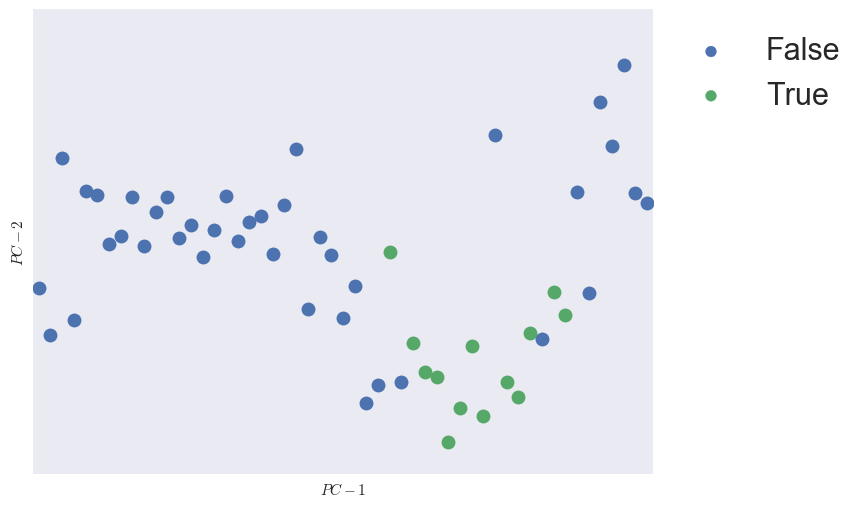

In [38]:
niche='Formula'
# This command will output a clr-PCA plot for a specified mapping file catagory (we will reuse niche here)
fig,OTUweightsPC1,OTUweightsPC2=untangle.pca_plot(sfotus,sfmappingdf,niche)
plt.show()

## We can now see the OTUs that are causing the clustering difference between the pre and post solid food groups along PC-1

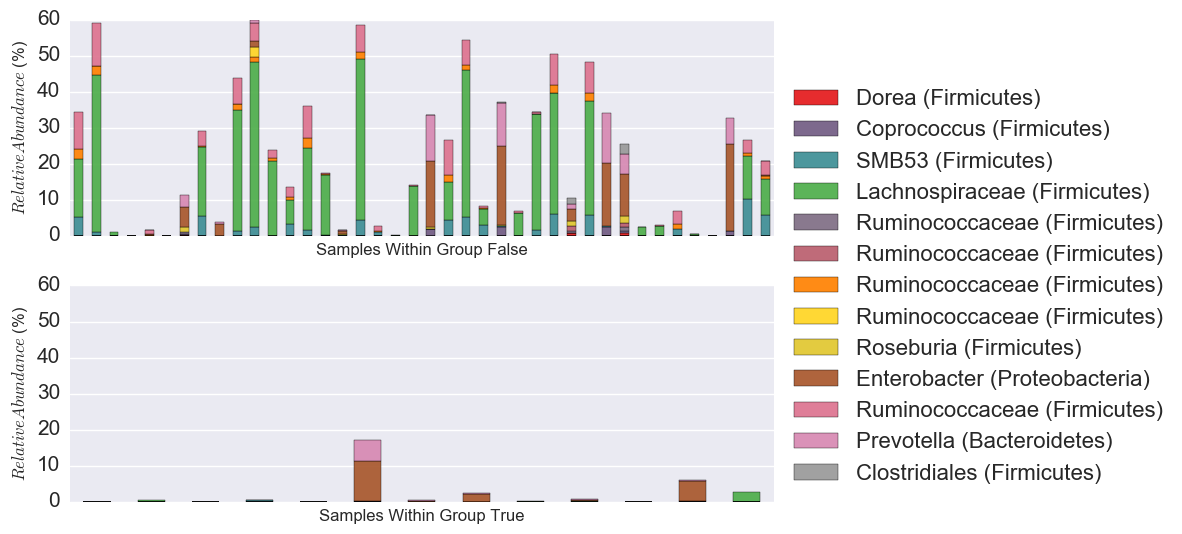

In [41]:
#plot 
#Note: we are using PC-2 here because the clusters are along that axis
n=13 #this will tell the command how many bacteria to plot
# taxanames is from the biom import,, it is a mapping file of the taxaonomy for each OTU
fig=untangle.feature_vis(sfotus,sfmappingdf,list(OTUweightsPC2.index[:n]),niche,taxnames)
plt.show()

## From this we can conclude that the main OTU driver between the clusters is Firmicutes.

In [12]:
plt.close('all')

# [Next Example](https://github.com/cjm007/DEICODE/blob/master/Examples/sponge_biom.ipynb)